In [ ]:
# pip install ultralytics

In [ ]:
# pip install kagglehub

In [ ]:
import kagglehub

path = kagglehub.dataset_download("imtkaggleteam/chess-pieces-detection-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 66.0M/66.0M [00:01<00:00, 42.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/imtkaggleteam/chess-pieces-detection-image-dataset/versions/3


In [ ]:
from pathlib import Path

pathname = "/kaggle/input/chess-pieces-detection-image-dataset"
p = Path(path)

# print top-level path
print("Root:", p)

# list all immediate subdirectories
subdirs = [x for x in p.iterdir() if x.is_dir()]
print("\nImmediate subdirectories:")
for s in subdirs:
    print(" -", s.name)

# print all subdirectories recursively:
print("\nAll subdirectories (recursive):")
for s in p.rglob("*"):
    if s.is_dir():
        print(" -", s.relative_to(p))

Root: /root/.cache/kagglehub/datasets/imtkaggleteam/chess-pieces-detection-image-dataset/versions/3

Immediate subdirectories:
 - Chess_pieces
 - Chess Pieces.yolov8-obb

All subdirectories (recursive):
 - Chess_pieces
 - Chess Pieces.yolov8-obb
 - Chess_pieces/valid
 - Chess_pieces/train
 - Chess_pieces/test
 - Chess Pieces.yolov8-obb/valid
 - Chess Pieces.yolov8-obb/train
 - Chess Pieces.yolov8-obb/test
 - Chess_pieces/valid/images
 - Chess_pieces/valid/labels
 - Chess_pieces/train/images
 - Chess_pieces/train/labels
 - Chess_pieces/test/images
 - Chess_pieces/test/labels
 - Chess Pieces.yolov8-obb/valid/images
 - Chess Pieces.yolov8-obb/valid/labels
 - Chess Pieces.yolov8-obb/train/images
 - Chess Pieces.yolov8-obb/train/labels
 - Chess Pieces.yolov8-obb/test/images
 - Chess Pieces.yolov8-obb/test/labels


In [ ]:
import yaml
from ultralytics import YOLO

root = p

# 1) Find any YAMLs (handles 'data.yaml' and 'data.yaml.yaml')
yamls = list(root.rglob("data.yaml")) + list(root.rglob("data.yaml.yaml")) # search recursively for these two data files
print("Found YAMLs:")
for y in yamls: print(" -", y)


# Prefer the standard detection set over OBB unless only OBB exists
# is_obb function takes
def is_obb(p: Path):
  return "obb" in str(p).lower() # the lower() method returns a string where all characters are lower case.
                                 # Checks if the lowercase string contains the substring "obb".
                                 # It returns True if it does, and False otherwise.


yaml_path = next((y for y in yamls if not is_obb(y)), None) or (yamls[0] if yamls else None)
assert yaml_path is not None, "No data.yaml found anywhere under the dataset root."

print("\nUsing:", yaml_path)

# 2) Peek class names / splits
cfg = yaml.safe_load(open(yaml_path, "r"))
print("\nYAML keys:", list(cfg.keys()))
print("Classes:", cfg.get("names"))

# 3) Train (choose weights/task based on OBB vs regular)
if is_obb(yaml_path):
    print("\nTraining OBB (oriented bounding boxes)")
    model = YOLO("yolo11n-obb.pt")             # you can use yolo11s-obb.pt etc.
    model.train(data=str(yaml_path), task="obb", imgsz=1024, epochs=50, batch=16)
    model.val(data=str(yaml_path), task="obb", split="test", imgsz=1024)
    model.predict(source=str(Path(yaml_path).parent / "valid" / "images"),
                  task="obb", imgsz=1024, conf=0.25, save=True)
else:
    print("\nTraining standard detection (axis-aligned boxes)")
    model = YOLO("yolo11n.pt")                 # you can use yolo11s.pt / m / l / x
    model.train(data=str(yaml_path), imgsz=640, epochs=50, batch=16)
    model.val(data=str(yaml_path), split="test", imgsz=640)
    model.predict(source=str(Path(yaml_path).parent / "valid" / "images"),
                  imgsz=640, conf=0.25, save=True)

print("\nDone. Check /kaggle/working/runs/* for results and saved predictions.")


Found YAMLs:
 - /root/.cache/kagglehub/datasets/imtkaggleteam/chess-pieces-detection-image-dataset/versions/3/Chess Pieces.yolov8-obb/data.yaml
 - /root/.cache/kagglehub/datasets/imtkaggleteam/chess-pieces-detection-image-dataset/versions/3/Chess_pieces/data.yaml.yaml

Using: /root/.cache/kagglehub/datasets/imtkaggleteam/chess-pieces-detection-image-dataset/versions/3/Chess_pieces/data.yaml.yaml

YAML keys: ['train', 'val', 'test', 'names']
Classes: {0: 'bishop', 1: 'black-bishop', 2: 'black-king', 3: 'black-knight', 4: 'black-pawn', 5: 'black-queen', 6: 'black-rook', 7: 'white-bishop', 8: 'white-king', 9: 'white-knight', 10: 'white-pawn', 11: 'white-queen', 12: 'white-rook'}

Training standard detection (axis-aligned boxes)
Ultralytics 8.3.203 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, comp

Contents: ['confusion_matrix_normalized.png', 'results.png', 'confusion_matrix.png', 'weights', 'BoxPR_curve.png', 'BoxR_curve.png', 'train_batch1.jpg', 'train_batch1521.jpg', 'train_batch2.jpg', 'BoxP_curve.png', 'train_batch0.jpg', 'args.yaml', 'val_batch0_pred.jpg', 'train_batch1522.jpg', 'val_batch1_pred.jpg', 'BoxF1_curve.png', 'val_batch1_labels.jpg', 'train_batch1520.jpg', 'val_batch0_labels.jpg', 'results.csv', 'labels.jpg']


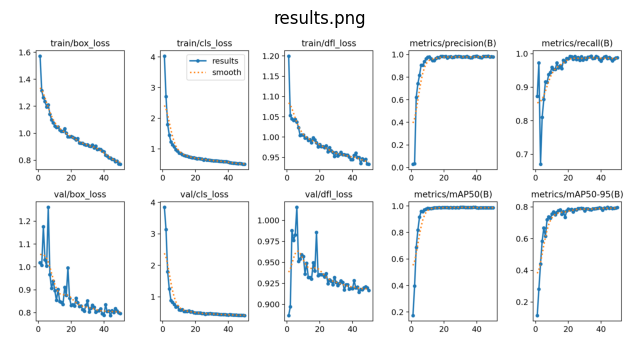

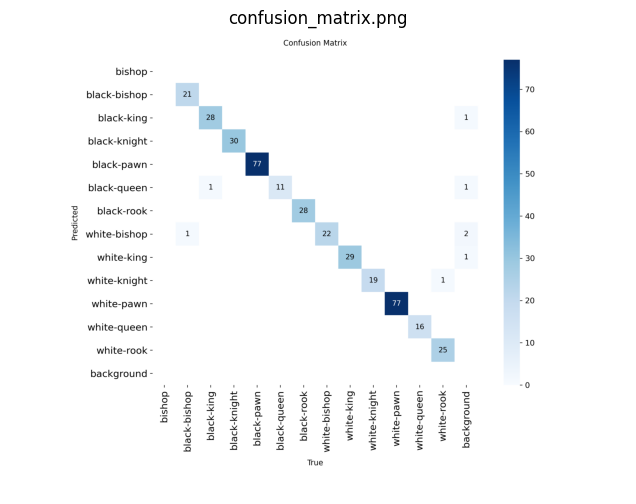

In [ ]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

run_dir = Path("/content/runs/detect/train")
print("Contents:", [p.name for p in run_dir.iterdir()])

for name in ["results.png","PR_curve.png","P_curve.png","R_curve.png","F1_curve.png","confusion_matrix.png"]:
    f = run_dir / name
    if f.exists():
        plt.figure(figsize=(8,6))
        plt.imshow(Image.open(f)); plt.axis("off"); plt.title(name)
        plt.show()
